## CNN-LSTM for AWS Spot Price Prediction


**Author: Sumaia Parveen Shupti, Siti Khotijah, Ruichong Wang**

Updated on: 06/11/2021

#### Important References: 

* [How to Convert a Time Series to a Supervised Learning Problem in Python](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)

* [Deep Learning for Time Series Forecasting](https://www.kaggle.com/dimitreoliveira/deep-learning-for-time-series-forecasting)
 
* [How can I obtain reproducible results using Keras during development?](https://keras.io/getting_started/faq/#how-to-do-hyperparameter-tuning-with-keras)


### Import Libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import initializers
import tensorflow as tf

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(0)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(0)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(0)

# Seed value (can actually be different for each attribution step)
seed_value= 0
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

In [2]:
import numpy as np
import os 
import random as rn
import tensorflow as tf
import keras
from tensorflow.compat.v1.keras import backend as K

#-----------------------------Keras reproducible------------------#
SEED = 0

tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
K.set_session(sess)
#-----------------------------------------------------------------#

### Loading data

In [3]:
# Importing Training Set
dataset_train = pd.read_csv('../input/flant-processed-data/train_test_train.csv')
train = dataset_train.copy()

import datetime as dt
dataset_train['Timestamp'] = pd.to_datetime(dataset_train['Timestamp'], format = '%Y-%m-%d %H:%M:%S.%f')
dataset_train['Date']= pd.to_datetime(dataset_train['Timestamp']).apply(lambda x: x.date())
dataset_train["Date"] = pd.to_datetime(dataset_train["Date"], format = '%Y-%m-%d')
dataset_train.head()

,AvailabilityZone,InstanceType,Timestamp,Timedel,SpotPrice,Date
0,0,0,2021-02-16 00:00:00+00:00,684.0,0.0671,2021-02-16
1,0,0,2021-02-16 01:00:00+00:00,720.0,0.0671,2021-02-16
2,0,0,2021-02-16 02:00:00+00:00,756.0,0.0671,2021-02-16
3,0,0,2021-02-16 03:00:00+00:00,792.0,0.0671,2021-02-16
4,0,0,2021-02-16 04:00:00+00:00,828.0,0.0671,2021-02-16


In [4]:
dataset_test = pd.read_csv('../input/flant-processed-data/train_test_test.csv')
dataset_test['Timestamp'] = pd.to_datetime(dataset_test['Timestamp'], format = '%Y-%m-%d %H:%M:%S.%f')
dataset_test['Date']= pd.to_datetime(dataset_test['Timestamp']).apply(lambda x: x.date())
dataset_test["Date"] = pd.to_datetime(dataset_test["Date"], format = '%Y-%m-%d')
dataset_test

,AvailabilityZone,InstanceType,Timestamp,Timedel,SpotPrice,Date
0,0,0,2021-04-10 00:00:00+00:00,46476.0,0.0671,2021-04-10
1,0,0,2021-04-10 01:00:00+00:00,46512.0,0.0671,2021-04-10
2,0,0,2021-04-10 02:00:00+00:00,46548.0,0.0671,2021-04-10
3,0,0,2021-04-10 03:00:00+00:00,46584.0,0.0671,2021-04-10
4,0,0,2021-04-10 04:00:00+00:00,46620.0,0.0671,2021-04-10
...,...,...,...,...,...,...
304910,5,388,2021-04-16 17:00:00+00:00,52272.0,0.1116,2021-04-16
304911,5,388,2021-04-16 18:00:00+00:00,52308.0,0.1116,2021-04-16
304912,5,388,2021-04-16 19:00:00+00:00,52344.0,0.1116,2021-04-16
304913,5,388,2021-04-16 20:00:00+00:00,52380.0,0.1116,2021-04-16


### Excluding the Timestamp Feature

In [5]:
def feat_eng(df):

    df.drop('Timestamp', axis = 1, inplace = True)
    df = df.reset_index(drop = True)

    print (df.shape)
    return df

### Train set

In [6]:
dataset_train = feat_eng(dataset_train)
dataset_train

(2289706, 5)


,AvailabilityZone,InstanceType,Timedel,SpotPrice,Date
0,0,0,684.0,0.0671,2021-02-16
1,0,0,720.0,0.0671,2021-02-16
2,0,0,756.0,0.0671,2021-02-16
3,0,0,792.0,0.0671,2021-02-16
4,0,0,828.0,0.0671,2021-02-16
...,...,...,...,...,...
2289701,5,388,46296.0,0.1116,2021-04-09
2289702,5,388,46332.0,0.1116,2021-04-09
2289703,5,388,46368.0,0.1116,2021-04-09
2289704,5,388,46404.0,0.1116,2021-04-09


### Test Set

In [7]:
dataset_test = feat_eng(dataset_test)
dataset_test

(304915, 5)


,AvailabilityZone,InstanceType,Timedel,SpotPrice,Date
0,0,0,46476.0,0.0671,2021-04-10
1,0,0,46512.0,0.0671,2021-04-10
2,0,0,46548.0,0.0671,2021-04-10
3,0,0,46584.0,0.0671,2021-04-10
4,0,0,46620.0,0.0671,2021-04-10
...,...,...,...,...,...
304910,5,388,52272.0,0.1116,2021-04-16
304911,5,388,52308.0,0.1116,2021-04-16
304912,5,388,52344.0,0.1116,2021-04-16
304913,5,388,52380.0,0.1116,2021-04-16


In [8]:
dataset_ = pd.concat([dataset_train, dataset_test])
dataset_

,AvailabilityZone,InstanceType,Timedel,SpotPrice,Date
0,0,0,684.0,0.0671,2021-02-16
1,0,0,720.0,0.0671,2021-02-16
2,0,0,756.0,0.0671,2021-02-16
3,0,0,792.0,0.0671,2021-02-16
4,0,0,828.0,0.0671,2021-02-16
...,...,...,...,...,...
304910,5,388,52272.0,0.1116,2021-04-16
304911,5,388,52308.0,0.1116,2021-04-16
304912,5,388,52344.0,0.1116,2021-04-16
304913,5,388,52380.0,0.1116,2021-04-16


### Transform the data into a time series problem

In [9]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### We will use the current hour and the last 1 hour to forecast 1 hour ahead

In [10]:
window = 3
lag = 1
series = series_to_supervised(dataset_.drop('Date', axis=1), window=window, lag=lag)
series

,AvailabilityZone(t-3),InstanceType(t-3),Timedel(t-3),SpotPrice(t-3),AvailabilityZone(t-2),InstanceType(t-2),Timedel(t-2),SpotPrice(t-2),AvailabilityZone(t-1),InstanceType(t-1),Timedel(t-1),SpotPrice(t-1),AvailabilityZone(t),InstanceType(t),Timedel(t),SpotPrice(t),AvailabilityZone(t+1),InstanceType(t+1),Timedel(t+1),SpotPrice(t+1)
3,0.0,0.0,684.0,0.0671,0.0,0.0,720.0,0.0671,0.0,0.0,756.0,0.0671,0,0,792.0,0.0671,0.0,0.0,828.0,0.0671
4,0.0,0.0,720.0,0.0671,0.0,0.0,756.0,0.0671,0.0,0.0,792.0,0.0671,0,0,828.0,0.0671,0.0,0.0,864.0,0.0671
5,0.0,0.0,756.0,0.0671,0.0,0.0,792.0,0.0671,0.0,0.0,828.0,0.0671,0,0,864.0,0.0671,0.0,0.0,900.0,0.0671
6,0.0,0.0,792.0,0.0671,0.0,0.0,828.0,0.0671,0.0,0.0,864.0,0.0671,0,0,900.0,0.0671,0.0,0.0,936.0,0.0671
7,0.0,0.0,828.0,0.0671,0.0,0.0,864.0,0.0671,0.0,0.0,900.0,0.0671,0,0,936.0,0.0671,0.0,0.0,972.0,0.0671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304909,5.0,388.0,52128.0,0.1116,5.0,388.0,52164.0,0.1116,5.0,388.0,52200.0,0.1116,5,388,52236.0,0.1116,5.0,388.0,52272.0,0.1116
304910,5.0,388.0,52164.0,0.1116,5.0,388.0,52200.0,0.1116,5.0,388.0,52236.0,0.1116,5,388,52272.0,0.1116,5.0,388.0,52308.0,0.1116
304911,5.0,388.0,52200.0,0.1116,5.0,388.0,52236.0,0.1116,5.0,388.0,52272.0,0.1116,5,388,52308.0,0.1116,5.0,388.0,52344.0,0.1116
304912,5.0,388.0,52236.0,0.1116,5.0,388.0,52272.0,0.1116,5.0,388.0,52308.0,0.1116,5,388,52344.0,0.1116,5.0,388.0,52380.0,0.1116


### Remove unwanted columns

In [11]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['AvailabilityZone', 'InstanceType', 'Timedel']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['AvailabilityZone', 'InstanceType', 'Timedel']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['AvailabilityZone(t)', 'InstanceType(t)', 'Timedel(t)'], axis=1, inplace=True)

In [12]:
series

,SpotPrice(t-3),SpotPrice(t-2),SpotPrice(t-1),SpotPrice(t),SpotPrice(t+1)
3,0.0671,0.0671,0.0671,0.0671,0.0671
4,0.0671,0.0671,0.0671,0.0671,0.0671
5,0.0671,0.0671,0.0671,0.0671,0.0671
6,0.0671,0.0671,0.0671,0.0671,0.0671
7,0.0671,0.0671,0.0671,0.0671,0.0671
...,...,...,...,...,...
304909,0.1116,0.1116,0.1116,0.1116,0.1116
304910,0.1116,0.1116,0.1116,0.1116,0.1116
304911,0.1116,0.1116,0.1116,0.1116,0.1116
304912,0.1116,0.1116,0.1116,0.1116,0.1116


### Train/validation split

In [13]:
lag_size = 1 

# Label
labels_col = 'SpotPrice(t+%d)' % lag_size
labels = series[[labels_col]]
series = series.drop(labels_col, axis=1)
series

,SpotPrice(t-3),SpotPrice(t-2),SpotPrice(t-1),SpotPrice(t)
3,0.0671,0.0671,0.0671,0.0671
4,0.0671,0.0671,0.0671,0.0671
5,0.0671,0.0671,0.0671,0.0671
6,0.0671,0.0671,0.0671,0.0671
7,0.0671,0.0671,0.0671,0.0671
...,...,...,...,...
304909,0.1116,0.1116,0.1116,0.1116
304910,0.1116,0.1116,0.1116,0.1116
304911,0.1116,0.1116,0.1116,0.1116
304912,0.1116,0.1116,0.1116,0.1116


In [14]:
labels

,SpotPrice(t+1)
3,0.0671
4,0.0671
5,0.0671
6,0.0671
7,0.0671
...,...
304909,0.1116
304910,0.1116
304911,0.1116
304912,0.1116


In [15]:
series.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2594617 entries, 3 to 304913
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   SpotPrice(t-3)  float64
 1   SpotPrice(t-2)  float64
 2   SpotPrice(t-1)  float64
 3   SpotPrice(t)    float64
dtypes: float64(4)
memory usage: 99.0 MB


In [16]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2594617 entries, 3 to 304913
Data columns (total 1 columns):
 #   Column          Dtype  
---  ------          -----  
 0   SpotPrice(t+1)  float64
dtypes: float64(1)
memory usage: 39.6 MB


In [17]:
X_train = series[:len(dataset_train)- window]
X_train

,SpotPrice(t-3),SpotPrice(t-2),SpotPrice(t-1),SpotPrice(t)
3,0.0671,0.0671,0.0671,0.0671
4,0.0671,0.0671,0.0671,0.0671
5,0.0671,0.0671,0.0671,0.0671
6,0.0671,0.0671,0.0671,0.0671
7,0.0671,0.0671,0.0671,0.0671
...,...,...,...,...
2289701,0.1116,0.1116,0.1116,0.1116
2289702,0.1116,0.1116,0.1116,0.1116
2289703,0.1116,0.1116,0.1116,0.1116
2289704,0.1116,0.1116,0.1116,0.1116


In [18]:
Y_train = labels[:len(dataset_train)- window]
Y_train

,SpotPrice(t+1)
3,0.0671
4,0.0671
5,0.0671
6,0.0671
7,0.0671
...,...
2289701,0.1116
2289702,0.1116
2289703,0.1116
2289704,0.1116


In [19]:
X_valid = series[len(dataset_train)- window:]
X_valid

,SpotPrice(t-3),SpotPrice(t-2),SpotPrice(t-1),SpotPrice(t)
0,0.1116,0.1116,0.1116,0.0671
1,0.1116,0.1116,0.0671,0.0671
2,0.1116,0.0671,0.0671,0.0671
3,0.0671,0.0671,0.0671,0.0671
4,0.0671,0.0671,0.0671,0.0671
...,...,...,...,...
304909,0.1116,0.1116,0.1116,0.1116
304910,0.1116,0.1116,0.1116,0.1116
304911,0.1116,0.1116,0.1116,0.1116
304912,0.1116,0.1116,0.1116,0.1116


In [20]:
Y_valid = labels[len(dataset_train)- window:]
Y_valid

,SpotPrice(t+1)
0,0.0671
1,0.0671
2,0.0671
3,0.0671
4,0.0671
...,...
304909,0.1116
304910,0.1116
304911,0.1116
304912,0.1116


### Optimizing the memory usage

In [21]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

### Let's look at the memory usage given by df.info()

In [22]:
X_train = reduce_mem_usage(X_train)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2289703 entries, 3 to 2289705
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   SpotPrice(t-3)  float16
 1   SpotPrice(t-2)  float16
 2   SpotPrice(t-1)  float16
 3   SpotPrice(t)    float16
dtypes: float16(4)
memory usage: 34.9 MB


In [23]:
X_valid = reduce_mem_usage(X_valid)
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304914 entries, 0 to 304913
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SpotPrice(t-3)  304914 non-null  float16
 1   SpotPrice(t-2)  304914 non-null  float16
 2   SpotPrice(t-1)  304914 non-null  float16
 3   SpotPrice(t)    304914 non-null  float16
dtypes: float16(4)
memory usage: 4.7 MB


In [24]:
Y_train = reduce_mem_usage(Y_train)
Y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2289703 entries, 3 to 2289705
Data columns (total 1 columns):
 #   Column          Dtype  
---  ------          -----  
 0   SpotPrice(t+1)  float16
dtypes: float16(1)
memory usage: 21.8 MB


In [25]:
Y_valid = reduce_mem_usage(Y_valid)
Y_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304914 entries, 0 to 304913
Data columns (total 1 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SpotPrice(t+1)  304914 non-null  float16
dtypes: float16(1)
memory usage: 2.9 MB


### Turning into string => float => numpy array also helps..

In [26]:
def mem_opt(t_set):
    
    cols = t_set.columns.tolist()
    t_set = t_set[cols].astype(str)
    t_set = t_set.astype(float)
    t_set = t_set.to_numpy()
    print (t_set.shape)
    return t_set

In [27]:
X_train = mem_opt(X_train)

(2289703, 4)


In [28]:
X_valid = mem_opt(X_valid)

(304914, 4)


In [29]:
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)

print('Train labels shape', Y_train.shape)
print('Validation labels shape', Y_valid.shape)

Train set shape (2289703, 4)
Validation set shape (304914, 4)
Train labels shape (2289703, 1)
Validation labels shape (304914, 1)


### CNN-LSTM for Time Series Forecasting

* Input shape **[samples, subsequences, timesteps, 1]**.

### Model explanation

"The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."

"When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."

"The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

### Data preprocess

* Reshape from **[samples, timesteps]** into **[samples, timesteps, 1]**.

* Reshape from **[samples, timesteps, 1]** into **[samples, subsequences, timesteps, 1]**.

*Note*: **timestep = window + lag**

In our case, **window = 3**, **lag = 1**.


In [30]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (2289703, 4, 1)
Validation set shape (304914, 4, 1)


### Model Development

In [31]:
subsequences = 1
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (2289703, 1, 4, 1)
Validation set shape (304914, 1, 4, 1)


In [32]:
epochs = 100
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

In [33]:
#initializer = tf.keras.initializers.GlorotUniform(seed=0)
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mae', optimizer='adam')

In [34]:
%%time
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=1, callbacks=[es, mcp])

Epoch 1/100
71554/71554 [==============================] - 146s 2ms/step - loss: 0.0079 - val_loss: 0.0066

Epoch 00001: val_loss improved from inf to 0.00657, saving model to weights.h5
Epoch 2/100
71554/71554 [==============================] - 142s 2ms/step - loss: 0.0029 - val_loss: 0.0067

Epoch 00002: val_loss did not improve from 0.00657
Epoch 3/100
71554/71554 [==============================] - 141s 2ms/step - loss: 0.0028 - val_loss: 0.0069

Epoch 00003: val_loss did not improve from 0.00657
Epoch 4/100
71554/71554 [==============================] - 142s 2ms/step - loss: 0.0026 - val_loss: 0.0106

Epoch 00004: val_loss did not improve from 0.00657
Epoch 5/100
71554/71554 [==============================] - 142s 2ms/step - loss: 0.0024 - val_loss: 0.0069

Epoch 00005: val_loss did not improve from 0.00657
Epoch 6/100
71554/71554 [==============================] - 142s 2ms/step - loss: 0.0023 - val_loss: 0.0060

Epoch 00006: val_loss improved from 0.00657 to 0.00604, saving model 

### Prediction on the Test Set

In [35]:
%%time
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)

CPU times: user 10.5 s, sys: 1.61 s, total: 12.1 s
Wall time: 7.6 s


In [36]:
comparison = pd.read_csv('../input/flant-processed-data/train_test_test.csv')
comparison = comparison[:len(dataset_test)-lag]
comparison['Predicted_Price'] = cnn_lstm_valid_pred
comparison.columns =['AvailabilityZone', 'InstanceType', 'Timestamp', 'Timedel', 'Actual_Price', 'Predicted_Price']
comparison

,AvailabilityZone,InstanceType,Timestamp,Timedel,Actual_Price,Predicted_Price
0,0,0,2021-04-10 00:00:00+00:00,46476.0,0.0671,0.077723
1,0,0,2021-04-10 01:00:00+00:00,46512.0,0.0671,0.067627
2,0,0,2021-04-10 02:00:00+00:00,46548.0,0.0671,0.067457
3,0,0,2021-04-10 03:00:00+00:00,46584.0,0.0671,0.067221
4,0,0,2021-04-10 04:00:00+00:00,46620.0,0.0671,0.067221
...,...,...,...,...,...,...
304909,5,388,2021-04-16 16:00:00+00:00,52236.0,0.1116,0.111655
304910,5,388,2021-04-16 17:00:00+00:00,52272.0,0.1116,0.111655
304911,5,388,2021-04-16 18:00:00+00:00,52308.0,0.1116,0.111655
304912,5,388,2021-04-16 19:00:00+00:00,52344.0,0.1116,0.111655


In [37]:
%%time
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)

CPU times: user 1min 19s, sys: 12.1 s, total: 1min 31s
Wall time: 56.9 s


### Prediction on the Training Set

In [38]:
cnn_lstm_train_pred.shape

(2289703, 1)

In [39]:
comparison_train = pd.read_csv('../input/flant-processed-data/train_test_train.csv')
comparison_train = comparison_train[window:]
comparison_train['Predicted_Price'] = cnn_lstm_train_pred
comparison_train.columns =['AvailabilityZone', 'InstanceType', 'Timestamp', 'Timedel', 'Actual_Price', 'Predicted_Price']
comparison_train

,AvailabilityZone,InstanceType,Timestamp,Timedel,Actual_Price,Predicted_Price
3,0,0,2021-02-16 03:00:00+00:00,792.0,0.0671,0.067221
4,0,0,2021-02-16 04:00:00+00:00,828.0,0.0671,0.067221
5,0,0,2021-02-16 05:00:00+00:00,864.0,0.0671,0.067221
6,0,0,2021-02-16 06:00:00+00:00,900.0,0.0671,0.067221
7,0,0,2021-02-16 07:00:00+00:00,936.0,0.0671,0.067221
...,...,...,...,...,...,...
2289701,5,388,2021-04-09 19:00:00+00:00,46296.0,0.1116,0.111655
2289702,5,388,2021-04-09 20:00:00+00:00,46332.0,0.1116,0.111655
2289703,5,388,2021-04-09 21:00:00+00:00,46368.0,0.1116,0.111655
2289704,5,388,2021-04-09 22:00:00+00:00,46404.0,0.1116,0.111655


### Plot Model Performance

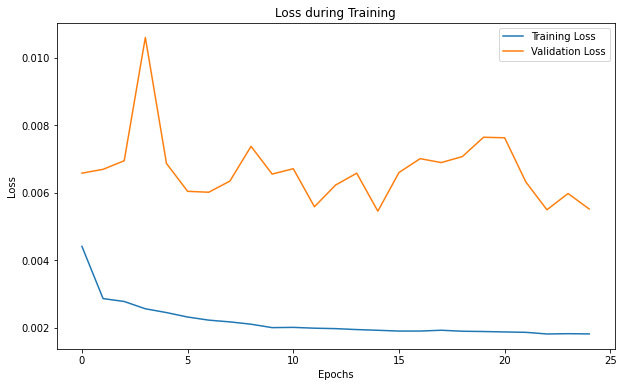

In [42]:
plt.figure(figsize = (10, 6))
plt.plot(cnn_lstm_history.history['loss'], label='Training Loss')
plt.plot(cnn_lstm_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title("Loss during Training")
plt.show()

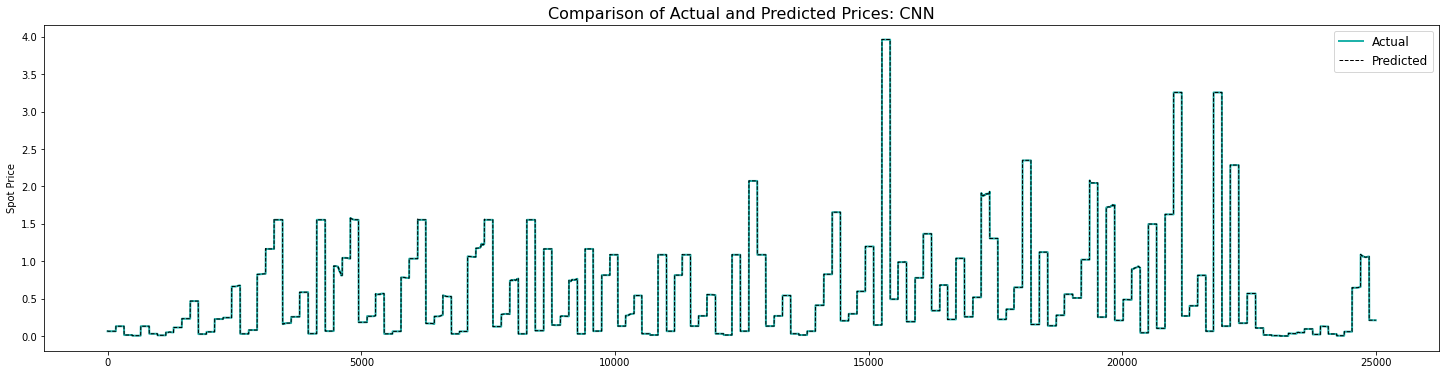

In [43]:
plt.rcParams["figure.figsize"] = [25, 6]

comparison.Actual_Price[:25000].plot(linewidth = 2, label = 'Actual', color = 'lightseagreen')
comparison.Predicted_Price[:25000].plot(linewidth = 1, label = 'Predicted', color = 'black', linestyle = '--')
plt.legend(fontsize = 'large')
plt.ylabel('Spot Price')
plt.title('Comparison of Actual and Predicted Prices: CNN', fontsize = 16)
plt.show()

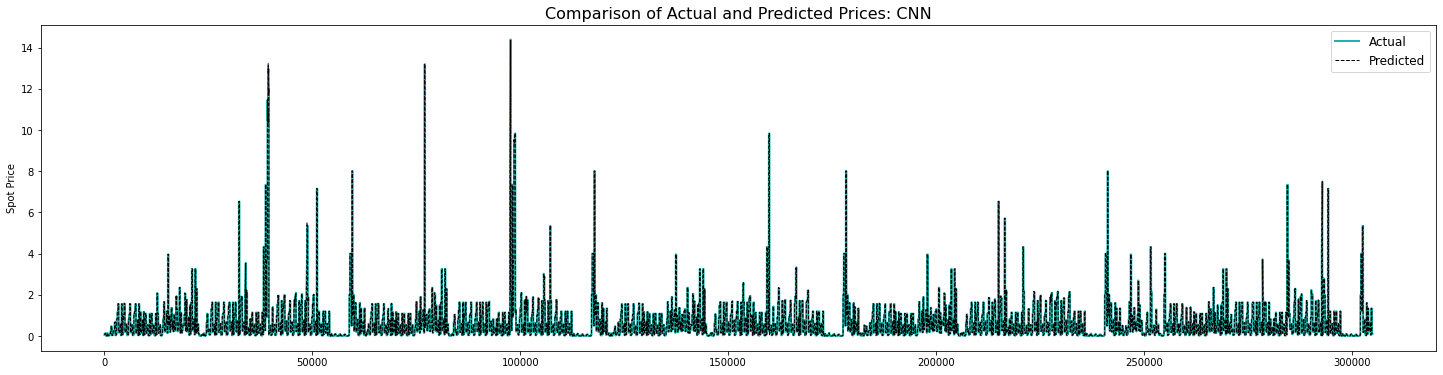

In [44]:
plt.rcParams["figure.figsize"] = [25, 6]

comparison.Actual_Price.plot(linewidth = 2, label = 'Actual', color = 'lightseagreen')
comparison.Predicted_Price.plot(linewidth = 1, label = 'Predicted', color = 'black', linestyle = '--')
plt.legend(fontsize = 'large')
plt.ylabel('Spot Price')
plt.title('Comparison of Actual and Predicted Prices: CNN', fontsize = 16)
plt.show()

### Evaluation on Test Set

In [45]:
# Define a function to calculate MAE and RMSE
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

errors = comparison['Actual_Price'] - comparison['Predicted_Price']
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()
mape = np.abs(errors/comparison['Actual_Price']).mean() * 100
r2 = r2_score(comparison['Actual_Price'], comparison['Predicted_Price'])

In [46]:
print('Mean Absolute Error: {:.4f}'.format(mae))
print('Root Mean Square Error: {:.4f}'.format(rmse))
print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
print('R2 Score: {:.4f}'.format(r2))

Mean Absolute Error: 0.0004
Root Mean Square Error: 0.0027
Mean Absolute Percentage Error: 0.4834
R2 Score: 1.0000


### Evaluation on Training Set

In [47]:
# Define a function to calculate MAE and RMSE
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

errors = comparison_train['Actual_Price'] - comparison_train['Predicted_Price']
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()
mape = np.abs(errors/comparison_train['Actual_Price']).mean() * 100
r2 = r2_score(comparison_train['Actual_Price'], comparison_train['Predicted_Price'])

In [48]:
print('Mean Absolute Error: {:.4f}'.format(mae))
print('Root Mean Square Error: {:.4f}'.format(rmse))
print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
print('R2 Score: {:.4f}'.format(r2))

Mean Absolute Error: 0.0003
Root Mean Square Error: 0.0014
Mean Absolute Percentage Error: 0.3690
R2 Score: 1.0000
